In [2]:
import glob
import numpy as np
import pandas as pd
import os
import shutil 
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
import cv2
%matplotlib inline

In [3]:
 def import_images(path):
    images = []
    for img in glob.glob(path):
        n = cv2.imread(img)
        images.append(n)
    return images

In [4]:
# import images
x_normal = import_images("pothole-detection-dataset/norma/*.jpg")
x_potholes = import_images("pothole-detection-dataset/potholes/*.jpg") 

In [5]:
X_normal = x_normal

In [6]:
X_potholes = x_potholes

In [7]:
 def pothole_resize(x_potholes,y,z):
    x_pothole__resized = []
    for i in range(len(x_potholes)):
        x = cv2.resize(x_potholes[i],(y,z))
        x_pothole__resized.append(x)
    return x_pothole__resized

In [8]:
x_pot = pothole_resize(x_potholes,224,224)

In [9]:
x_nor = pothole_resize(x_normal,224,224)
label = np.zeros(len(x_nor))
x = x_nor
for i in x_pot:
    x.append(i)
x = np.array(x)
label1 = np.ones(len(x_pot))
labels = np.concatenate((label,label1),axis = 0)
print(labels.shape)

(678,)


In [29]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(x,labels,test_size = 0.25,random_state = 42)

In [30]:
X_train_scaled = X_train.astype("float32")

In [31]:
X_test_scaled = X_test.astype("float32")

In [32]:
X_train_scaled /= 255
X_test_scaled /= 255

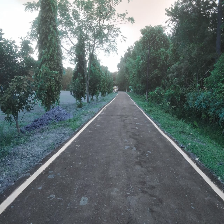

In [33]:
array_to_img(X_train[300])

In [34]:
# applying data augementatioin
train_datagen = ImageDataGenerator(zoom_range =0.1,rotation_range = 50,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,horizontal_flip=True,fill_mode='nearest')
val_datagen = ImageDataGenerator()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels: [0.0, 0.0, 0.0, 0.0, 0.0]


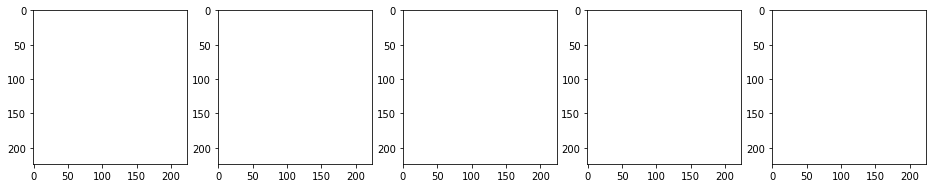

In [35]:
# to visualize the data augmentation
img_id = 300
pothole_generator = train_datagen.flow(X_train[img_id:img_id+1], 
 y_train[img_id:img_id+1], 
 batch_size=1) 
pothole = [next(pothole_generator) for i in range(0,5)] 
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in pothole]) 
l = [ax[i].imshow(pothole[i][0][0]) for i in range(0,5)]

In [36]:
train_generator = train_datagen.flow(X_train,y_train,batch_size=30)

In [37]:
# using pretrained model resnet50
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
import keras

In [38]:
restnet = ResNet50(weights='imagenet', input_shape=(224,224,3))
output = restnet.layers[-2].output
#output = keras.layers.Flatten()(output)
restnet = Model(restnet.input, outputs=output)
for layer in restnet.layers:
    layer.trainable = False
restnet.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [39]:
output.shape

TensorShape([Dimension(None), Dimension(2048)])

In [40]:
from tensorflow.keras.layers import Conv2D,Flatten, Dense, Dropout, InputLayer,GlobalAveragePooling2D
#from tensorflow.keras.layers.pooling import MaxPool2D
#from tensorflow.keras.layers.convolutional import Convolution2D,Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, Callback

In [41]:
def keras_model_transfer():
#     model = Sequential()
#     model.add(restnet)
#     model.add(Convolution2D(filters = 16, kernel_size=8, strides =(8,1),padding='valid', input_shape=output.shape))
#     # model.add(ELU())
#     model.add(Activation('relu'))
#     model.add(Convolution2D(filters =32, kernel_size =5,strides =(5,1), padding="same"))
#     # model.add(ELU())
#     model.add(Activation('relu'))
#     # model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
#     # model.add(Flatten())
#     model.add(GlobalAveragePooling2D())
#     # model.add(Dropout(.2))
#     # model.add(ELU())
#     # model.add(Activation('relu'))
#     # model.add(Dense(512,kernel_regularizer=regularizers.l2(0.00005)))

#     # model.add(Dense(1024))
#     # model.add(Dropout(.5))
#     # # model.add(ELU())
#     # model.add(Activation('relu'))

#     model.add(Dense(512))
#     model.add(Dropout(.5))
#     # model.add(ELU())
#     model.add(Activation('relu'))

#     # model.add(Dense(256))
#     # model.add(Dropout(.5))
#     # # model.add(ELU())
#     # model.add(Activation('relu'))
#     model.add(Dense(1))
#     model.add(Activation('softmax'))
    model = Sequential()
    model.add(restnet)
    model.add(Dense(512, activation='relu', input_dim=output.shape))
    model.add(Dropout(0.3))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [42]:
model = keras_model_transfer()

In [43]:
early = EarlyStopping(monitor='val_loss', patience = 10, verbose = 0)

In [44]:
model.compile('adam', 'binary_crossentropy', ['accuracy'])
history = model.fit(X_train, y_train, nb_epoch=100, callbacks=[early],validation_split=0.1)

Train on 457 samples, validate on 51 samples
Epoch 1/100
457/457 [==============================] - 63s 137ms/sample - loss: 0.2731 - acc: 0.8753 - val_loss: 0.0789 - val_acc: 0.9608
Epoch 2/100
457/457 [==============================] - 60s 130ms/sample - loss: 0.0802 - acc: 0.9737 - val_loss: 0.1334 - val_acc: 0.9608
Epoch 3/100
457/457 [==============================] - 60s 131ms/sample - loss: 0.0996 - acc: 0.9650 - val_loss: 0.1090 - val_acc: 0.9216
Epoch 4/100
457/457 [==============================] - 60s 130ms/sample - loss: 0.1238 - acc: 0.9694 - val_loss: 0.0413 - val_acc: 0.9804
Epoch 5/100
457/457 [==============================] - 60s 131ms/sample - loss: 0.1406 - acc: 0.9519 - val_loss: 0.0246 - val_acc: 1.0000
Epoch 6/100
457/457 [==============================] - 60s 131ms/sample - loss: 0.0548 - acc: 0.9891 - val_loss: 0.3075 - val_acc: 0.9412
Epoch 7/100
457/457 [==============================] - 60s 130ms/sample - loss: 0.0330 - acc: 0.9912 - val_loss: 0.0861 - val_a

In [45]:
# to evaluate
metrics = model.evaluate(X_test, y_test)
for metric_i in range(len(model.metrics_names)):
    metric_name = model.metrics_names[metric_i]
    metric_value = metrics[metric_i]
    print('{}: {}'.format(metric_name, metric_value))

170/170 [==============================] - 17s 98ms/sample - loss: 0.0856 - acc: 0.9706
loss: 0.08559044741970652
acc: 0.970588207244873


In [46]:
# to save weights
model.save("my_model_weights_tensor.h5")

In [36]:
# to save architecture
model_json = model.to_json()
with open("model_arch.json", "w") as json_file:
    json_file.write(model_json)

TypeError: ('Not JSON Serializable:', TensorShape([Dimension(None), Dimension(2048)]))